In [ ]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [4]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5))
])

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=data_transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=data_transform)

In [5]:
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=256, shuffle=True)

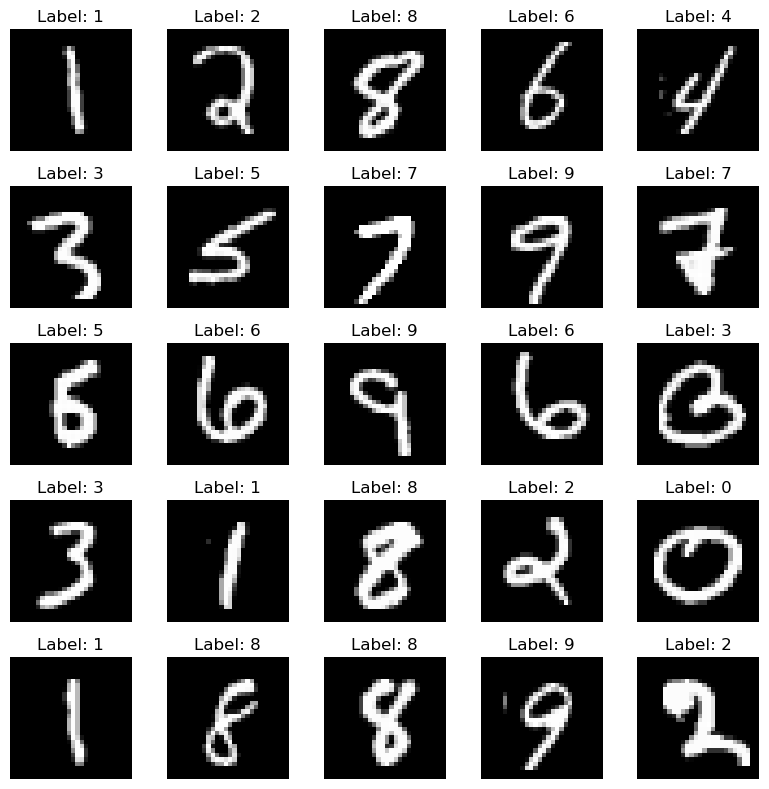

In [6]:
images, labels = next(iter(train_loader))

plt.figure(figsize=(8, 8))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].squeeze(), cmap='gray')  # squeeze to remove extra dimension
    plt.title(f"Label: {labels[i].item()}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [5]:
class BaselineClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.fc1 = nn.Linear(128*3*3, 625)
        self.fc2 = nn.Linear(625, 10)

        self.act = nn.ReLU()
        self.pooling = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # Layer 1: Conv -> ReLU -> MaxPool -> Dropout
        x = self.dropout(self.pooling(self.act(self.conv1(x))))

        # Layer 2: Conv -> ReLU -> MaxPool -> Dropout
        x = self.dropout(self.pooling(self.act(self.conv2(x))))

        # Layer 3: Conv -> ReLU -> MaxPool
        x = self.pooling(self.act(self.conv3(x)))

        x = torch.flatten(x, 1)
        
        # Layer 4: FC
        x = self.dropout(self.fc1(x))

        # Layer 5: FC
        x = self.fc2(x)

        return x

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Device is {device}")

Device is cuda:0


In [7]:
net = BaselineClassifier()
net.to(device)

BaselineClassifier(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1152, out_features=625, bias=True)
  (fc2): Linear(in_features=625, out_features=10, bias=True)
  (act): ReLU()
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(net.parameters(), lr=0.001, alpha=0.9)

In [10]:
losses = []

for epoch in range(10):

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 0:
            losses.append(running_loss / 100)
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0

[1,     1] loss: 0.023
[1,   101] loss: 0.727
[1,   201] loss: 0.156
[1,   301] loss: 0.108
[1,   401] loss: 0.080
[2,     1] loss: 0.000
[2,   101] loss: 0.064
[2,   201] loss: 0.061
[2,   301] loss: 0.059
[2,   401] loss: 0.053
[3,     1] loss: 0.000
[3,   101] loss: 0.043
[3,   201] loss: 0.043
[3,   301] loss: 0.044
[3,   401] loss: 0.047
[4,     1] loss: 0.000
[4,   101] loss: 0.035
[4,   201] loss: 0.038
[4,   301] loss: 0.038
[4,   401] loss: 0.039
[5,     1] loss: 0.000
[5,   101] loss: 0.030
[5,   201] loss: 0.034
[5,   301] loss: 0.029
[5,   401] loss: 0.034
[6,     1] loss: 0.000
[6,   101] loss: 0.028
[6,   201] loss: 0.027
[6,   301] loss: 0.029
[6,   401] loss: 0.029
[7,     1] loss: 0.000
[7,   101] loss: 0.027
[7,   201] loss: 0.026
[7,   301] loss: 0.021
[7,   401] loss: 0.027
[8,     1] loss: 0.000
[8,   101] loss: 0.023
[8,   201] loss: 0.020
[8,   301] loss: 0.024
[8,   401] loss: 0.026
[9,     1] loss: 0.000
[9,   101] loss: 0.018
[9,   201] loss: 0.021
[9,   301] 

In [11]:
# Save model
torch.save(net.state_dict(), './baseline.pth')

In [12]:
net.eval()

correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on test images: {100 * correct / total}%')

Accuracy of the network on test images: 99.32%
